# **Détection des URL Malveillantes**


Dans le domaine de la cybersécurité, la détection des URL malveillantes représente un enjeu majeur pour protéger les systèmes et les utilisateurs contre les menaces en ligne. Une URL malveillante peut servir de vecteur d'attaques variées, telles que le phishing, la diffusion de logiciels malveillants ou encore l'exfiltration de données sensibles. Ces attaques exploitent souvent des failles humaines ou techniques, rendant cruciale l'adoption de mécanismes de détection efficaces.

Le dataset étudié dans ce projet, issu de Kaggle, constitue une ressource précieuse pour l'avancement des recherches dans ce domaine. Il contient un ensemble diversifié d'URL (benignes et malveillantes) accompagnées de caractéristiques calculées couvrant plusieurs aspects, tels que les composants basiques des URL, les informations sur les domaines, l'analyse du contenu, les paramètres des chemins et des requêtes, ainsi que des informations sur les certificats SSL, la réputation de l’hôte et des comportements réseau.

***L’objectif de cette étude est de tirer parti de ces données pour développer des modèles performants de détection d’URL malveillantes en utilisant des approches d’apprentissage automatique et d’apprentissage profond.*** Grâce à la richesse et à la diversité des caractéristiques fournies, ce dataset offre une opportunité unique de concevoir des solutions innovantes et robustes pour la classification des URL.



## Initialisation


*   Initialisation des librairies nécessaires pour PySpark.
*   Configuration de la session Spark avec des paramètres spécifiques (mémoire, partitions, etc.).






In [ ]:
! pip install findspark

In [ ]:
# Initialisation des librairies pyspark
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.sql.functions import col, lit, log, sum
from pyspark.sql import functions as F

import numpy as np
import matplotlib.pyplot as plt

import findspark
findspark.init()

spark = SparkSession \
    .builder \
    .appName("Projet Finale") \
    .config("spark.driver.memory", "6g") \
    .config("spark.sql.shuffle.partitions", "16") \
    .config("spark.sql.debug.maxToStringFields", "100") \
    .getOrCreate()

24/12/07 23:25:13 WARN Utils: Your hostname, hale3105-Latitude-5490 resolves to a loopback address: 127.0.1.1; using 192.168.1.10 instead (on interface wlp2s0)
24/12/07 23:25:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 23:25:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


La configuration de la mémoire (6g) et des partitions de shuffle réduit le temps d'exécution en optimisant l'utilisation des ressources pour les datasets volumineux.

# 1. Chargement des données

Chargement des fichiers CSV pour les datasets d'entraînement et de test.

In [ ]:
# Lecture du fichier
# partie train
fileNameTrain = 'train_dataset.csv'
train_data = spark.read.csv(fileNameTrain, header=True, inferSchema=True)

# train_data = train_data.coalesce(16)
# partie test
fileNameTest = 'test_dataset.csv'
test_data = spark.read.csv(fileNameTest, header=True, inferSchema=True)

Affichage du schéma des colonnes pour vérifier les types de données.

In [ ]:
# afficher le schema
train_data.printSchema()

root
 |-- url: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- url_has_login: integer (nullable = true)
 |-- url_has_client: integer (nullable = true)
 |-- url_has_server: integer (nullable = true)
 |-- url_has_admin: integer (nullable = true)
 |-- url_has_ip: integer (nullable = true)
 |-- url_isshorted: integer (nullable = true)
 |-- url_len: integer (nullable = true)
 |-- url_entropy: double (nullable = true)
 |-- url_hamming_1: double (nullable = true)
 |-- url_hamming_00: double (nullable = true)
 |-- url_hamming_10: double (nullable = true)
 |-- url_hamming_01: double (nullable = true)
 |-- url_hamming_11: double (nullable = true)
 |-- url_2bentropy: double (nullable = true)
 |-- url_3bentropy: double (nullable = true)
 |-- url_count_dot: integer (nullable = true)
 |-- url_count_https: integer (nullable = true)
 |-- url_count_http: integer (nullable = true)
 |-- url_count_perc: integer (nullable = true)
 |-- url_count_hyph

# 2. Nettoyage des données

Nous supprimons les colonnes 'url' et 'tld' car elles contiennent des valeurs de type String et il existe déjà d'autres colonnes extraites de leurs caractéristiques (par exemple : 'url_count_dot', 'url_count_www').

Par conséquent, ces deux colonnes ne sont plus nécessaires.

In [ ]:
filtered_train = train_data.drop('url', 'tld').persist(StorageLevel.MEMORY_AND_DISK)
filtered_test = test_data.drop('url', 'tld').persist(StorageLevel.MEMORY_AND_DISK)

train_size = filtered_train.count()
test_size = filtered_test.count()

Élimination des doublons dans les données d'entraînement et de test.

In [ ]:
cleaned_train = filtered_train.dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)
cleaned_test = filtered_test.dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)

filtered_train.unpersist()
filtered_test.unpersist()

DataFrame[label: int, source: string, url_has_login: int, url_has_client: int, url_has_server: int, url_has_admin: int, url_has_ip: int, url_isshorted: int, url_len: int, url_entropy: double, url_hamming_1: double, url_hamming_00: double, url_hamming_10: double, url_hamming_01: double, url_hamming_11: double, url_2bentropy: double, url_3bentropy: double, url_count_dot: int, url_count_https: int, url_count_http: int, url_count_perc: int, url_count_hyphen: int, url_count_www: int, url_count_atrate: int, url_count_hash: int, url_count_semicolon: int, url_count_underscore: int, url_count_ques: int, url_count_equal: int, url_count_amp: int, url_count_letter: int, url_count_digit: int, url_count_sensitive_financial_words: int, url_count_sensitive_words: int, url_nunique_chars_ratio: double, path_len: int, path_count_no_of_dir: int, path_count_no_of_embed: int, path_count_zero: int, path_count_pertwent: int, path_has_any_sensitive_words: int, path_count_lower: int, path_count_upper: int, path

In [ ]:
print("Nombre de lignes supprimées à partir de: ")
print(f"train_data : {train_size - cleaned_train.count()}")
print(f"test_data : {test_size - cleaned_test.count()}")

Nombre de lignes supprimées à partir de: 


train_data : 130643


test_data : 10225


Calcul du nombre de valeurs nulles dans chaque colonne.

In [ ]:
null_counts = cleaned_train.select(
    *[sum(col(column).isNull().cast("int")).alias(column) for column in cleaned_train.columns]
)

null_counts.show()

+-----+------+-------------+--------------+--------------+-------------+----------+-------------+-------+-----------+-------------+--------------+--------------+--------------+--------------+-------------+-------------+-------------+---------------+--------------+--------------+----------------+-------------+----------------+--------------+-------------------+--------------------+--------------+---------------+-------------+----------------+---------------+-----------------------------------+-------------------------+-----------------------+--------+--------------------+----------------------+---------------+-------------------+----------------------------+----------------+----------------+-------------------+----------------------+-----------------+---------+----------------------+-----------+--------------------+--------------------+--------------------------+-------------------+-------+----------+--------------------+-------------+-------------------+
|label|source|url_has_login|url

In [ ]:
null_counts = cleaned_test.select(
    *[sum(col(column).isNull().cast("int")).alias(column) for column in cleaned_test.columns]
)

null_counts.show()

+-----+------+-------------+--------------+--------------+-------------+----------+-------------+-------+-----------+-------------+--------------+--------------+--------------+--------------+-------------+-------------+-------------+---------------+--------------+--------------+----------------+-------------+----------------+--------------+-------------------+--------------------+--------------+---------------+-------------+----------------+---------------+-----------------------------------+-------------------------+-----------------------+--------+--------------------+----------------------+---------------+-------------------+----------------------------+----------------+----------------+-------------------+----------------------+-----------------+---------+----------------------+-----------+--------------------+--------------------+--------------------------+-------------------+-------+----------+--------------------+-------------+-------------------+
|label|source|url_has_login|url

Ensuite, nous identifions les colonnes numériques asymétriques en calculant leur skewness et signalons celles qui dépassent un seuil défini.

Les données asymétriques peuvent fausser l'analyse, biaiser les modèles et affecter la mise à l'échelle. La transformation de ces colonnes améliore les performances et l'interprétabilité du modèle.

In [ ]:
feature_columns = cleaned_train.columns[1:]  # Exclure la première colonne ("label")
non_binary_columns = [
    col for col in feature_columns[1:] # Exclure la première colonne ("source"), qui est de type String
    if cleaned_train.select(col).distinct().count() > 2
]

# Calculer la skewness pour chaque colonne non binaire
skewness_results = (
    cleaned_train.select([F.skewness(col).alias(col) for col in non_binary_columns])
    .collect()[0].asDict()
)

# Identifier les colonnes considérées comme asymétriques (skewed)
threshold = 1
skewed_columns = [col for col, skew in skewness_results.items() if abs(skew) > threshold]

# Résultats
print(f"Le nombre de colonnes asymétriques : {len(skewed_columns)}")
print(f"Colonnes asymétriques : {skewed_columns}")

24/12/07 23:28:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Le nombre de colonnes asymétriques : 36
Colonnes asymétriques : ['url_len', 'url_count_dot', 'url_count_https', 'url_count_http', 'url_count_perc', 'url_count_hyphen', 'url_count_www', 'url_count_atrate', 'url_count_hash', 'url_count_semicolon', 'url_count_underscore', 'url_count_ques', 'url_count_equal', 'url_count_amp', 'url_count_letter', 'url_count_digit', 'url_count_sensitive_financial_words', 'url_count_sensitive_words', 'path_len', 'path_count_no_of_dir', 'path_count_no_of_embed', 'path_count_zero', 'path_count_pertwent', 'path_count_lower', 'path_count_upper', 'path_count_nonascii', 'query_len', 'query_count_components', 'pdomain_len', 'pdomain_count_hyphen', 'pdomain_count_non_alphanum', 'pdomain_count_digit', 'tld_len', 'pdomain_min_distance', 'subdomain_len', 'subdomain_count_dot']


In [ ]:
def histogram_plot(df, columns):
    num_col = len(columns)

    plt.figure(figsize=(30, 50))
    # Boucler sur chaque colonne du DataFrame et tracer son histogramme
    for i, column in enumerate(columns):
        bins, counts = df.select(column).rdd.flatMap(lambda x: x).histogram(20)
        plt.subplot(num_col // 3 + 1, 5, i + 1)
        plt.hist(bins[:-1], bins=bins, weights=counts, color='pink')
        plt.title(f'Histogramme de {column}')
        plt.xlabel(column)
        plt.ylabel('Fréquence')

    plt.tight_layout()
    plt.show()

Ici, nous visualisons pour avoir une meilleure vue des colonnes asymétriques

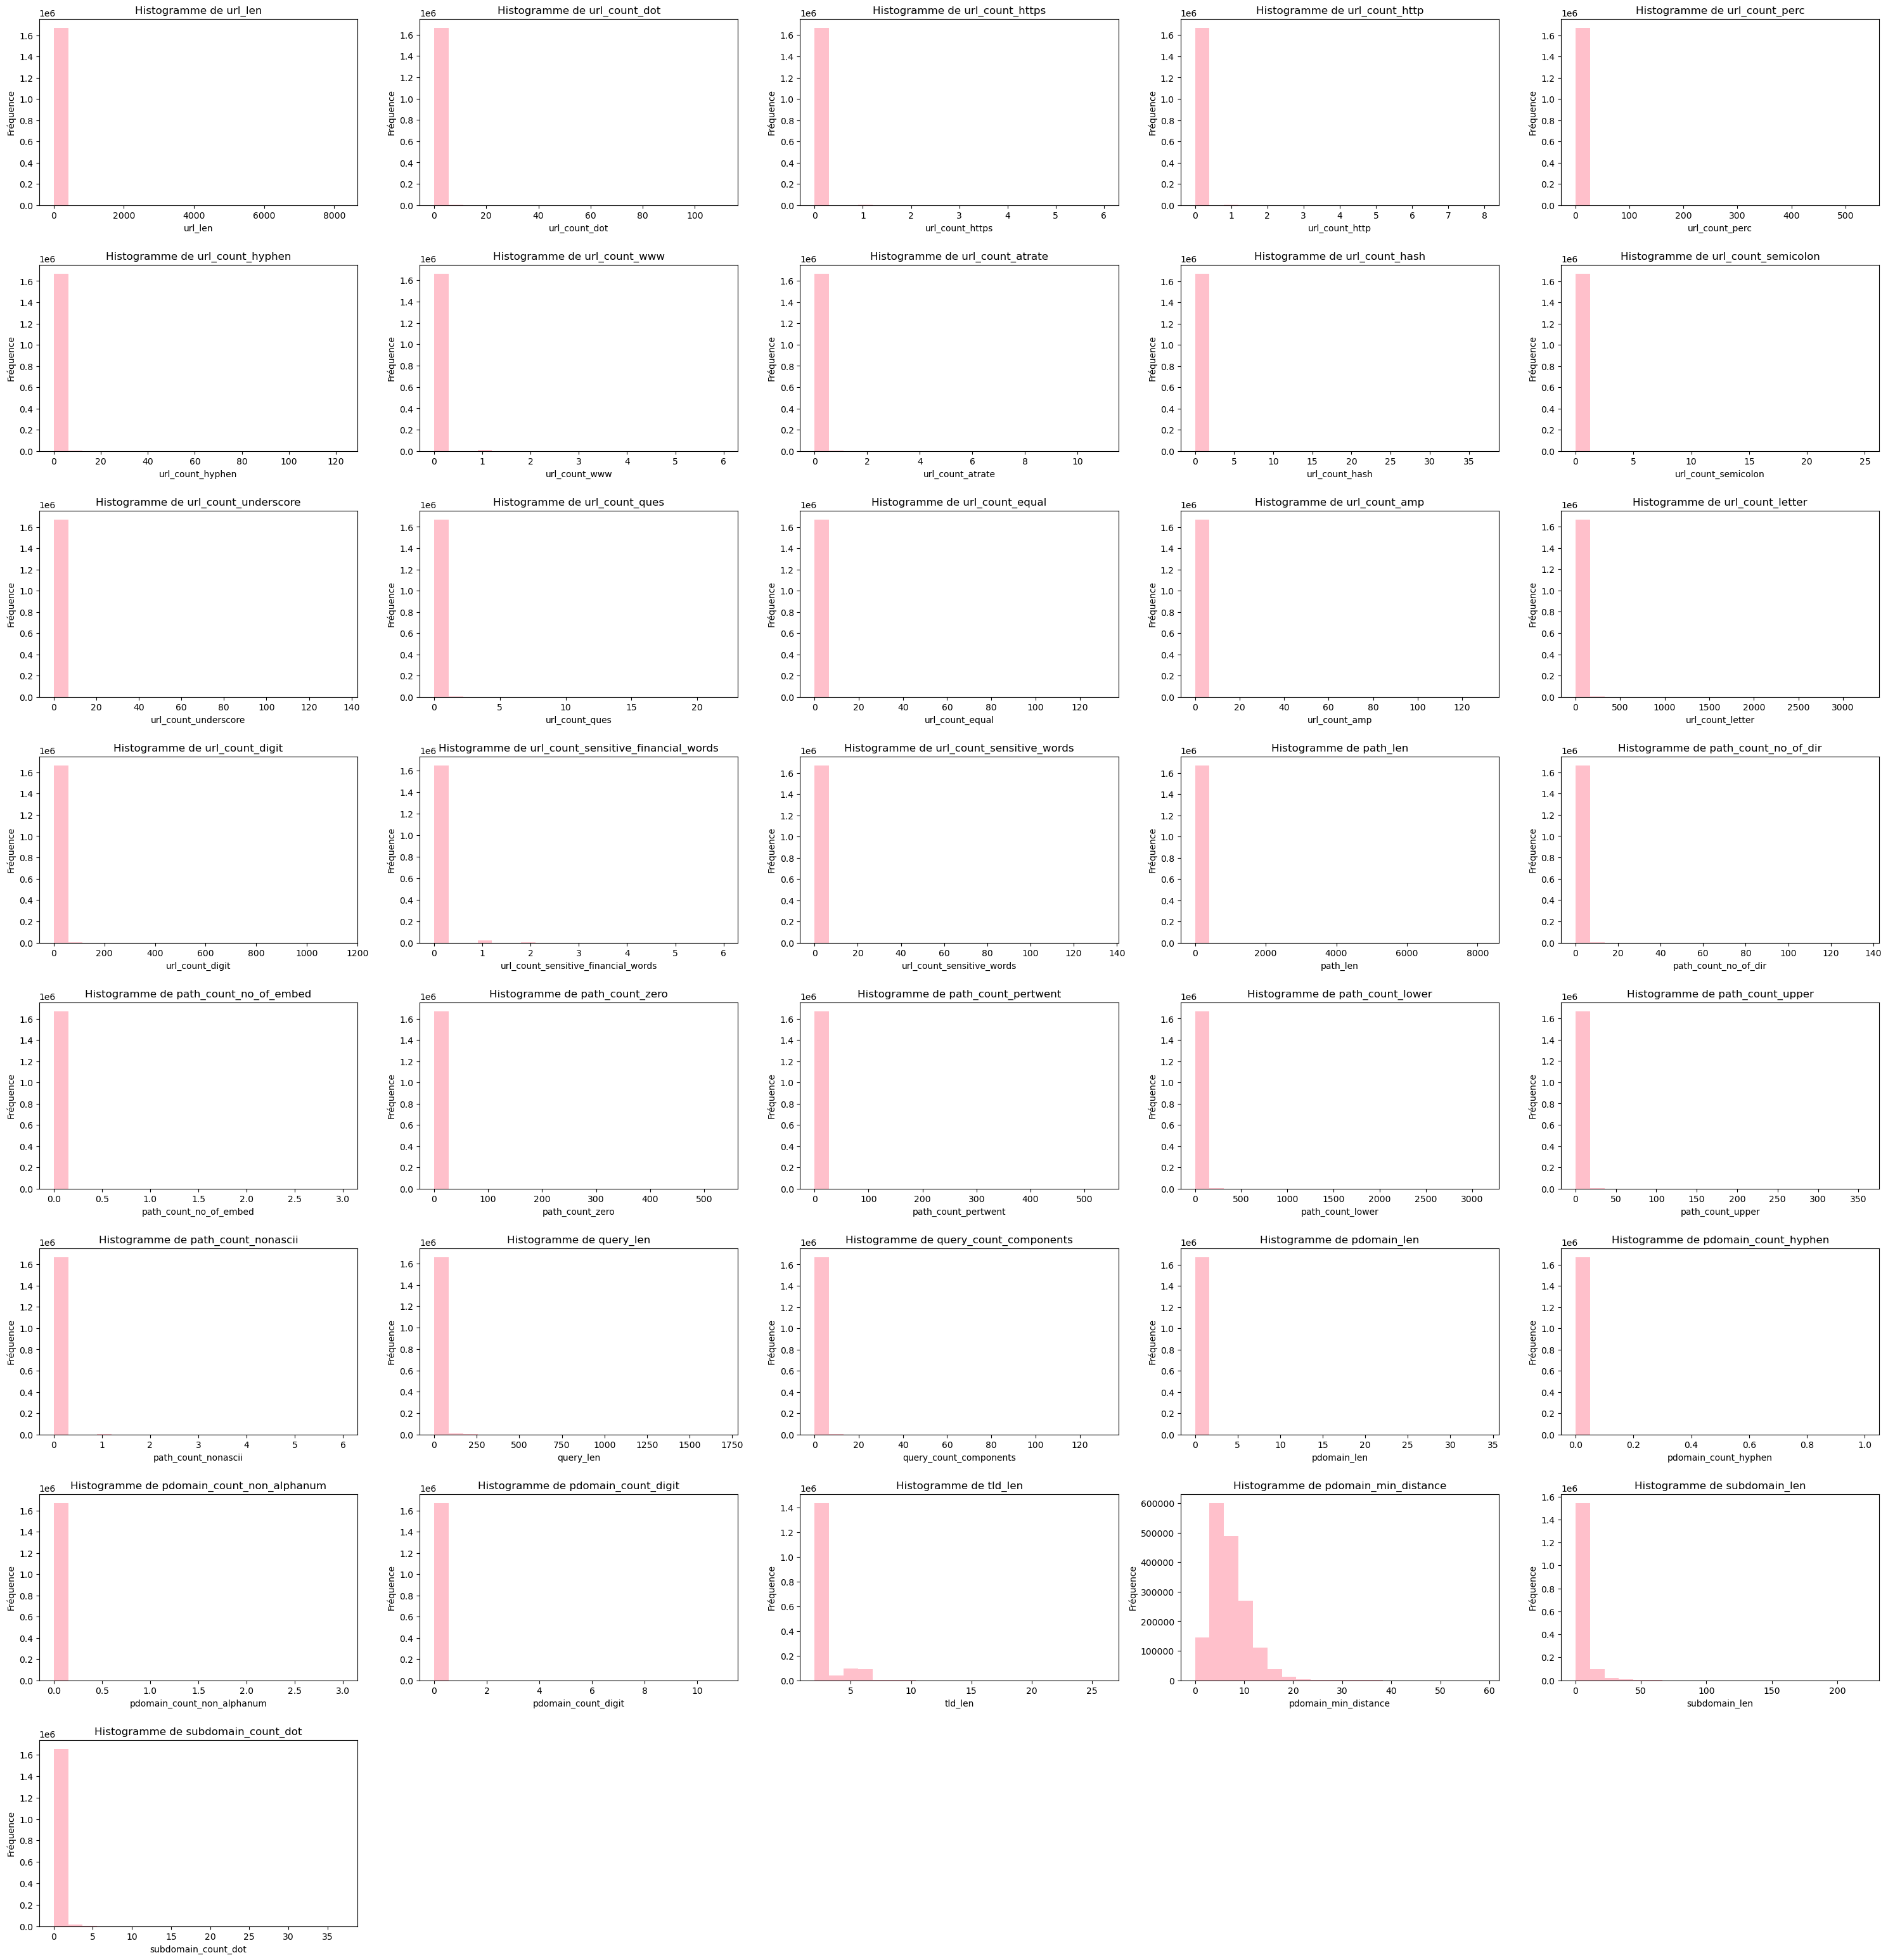

In [ ]:
histogram_plot(cleaned_test, skewed_columns)

La transformation logarithmique est bien adaptée pour réduire l'impact des valeurs extrêmes dans les colonnes asymétriques.

In [ ]:
non_skewed_columns = [col for col in feature_columns if col not in skewed_columns]

# Appliquer une transformation logarithmique sur les colonnes biaisées
epsilon = 1  # Constante pour gérer les valeurs nulles ou négatives
log_transformed_columns = [
    (col_name, log(col(col_name) + lit(epsilon)).alias(f"{col_name}_log"))
    for col_name in skewed_columns
]

# Appliquer les transformations logarithmiques aux DataFrames d'entraînement et de test
final_train = cleaned_train.select("*", *[log_expr for _, log_expr in log_transformed_columns]).persist(StorageLevel.MEMORY_AND_DISK)
final_test = cleaned_test.select("*", *[log_expr for _, log_expr in log_transformed_columns]).persist(StorageLevel.MEMORY_AND_DISK)

cleaned_train.unpersist()
cleaned_test.unpersist()

log_columns = [f"{col_name}_log" for col_name, _ in log_transformed_columns]
new_feature_columns = non_skewed_columns + log_columns# Combiner les colonnes biaisées transformées logarithmiquement avec les autres colonnes non biaisées
print(new_feature_columns)

['source', 'url_has_login', 'url_has_client', 'url_has_server', 'url_has_admin', 'url_has_ip', 'url_isshorted', 'url_entropy', 'url_hamming_1', 'url_hamming_00', 'url_hamming_10', 'url_hamming_01', 'url_hamming_11', 'url_2bentropy', 'url_3bentropy', 'url_nunique_chars_ratio', 'path_has_any_sensitive_words', 'path_has_singlechardir', 'path_has_upperdir', 'pdomain_count_atrate', 'tld_is_sus', 'url_len_log', 'url_count_dot_log', 'url_count_https_log', 'url_count_http_log', 'url_count_perc_log', 'url_count_hyphen_log', 'url_count_www_log', 'url_count_atrate_log', 'url_count_hash_log', 'url_count_semicolon_log', 'url_count_underscore_log', 'url_count_ques_log', 'url_count_equal_log', 'url_count_amp_log', 'url_count_letter_log', 'url_count_digit_log', 'url_count_sensitive_financial_words_log', 'url_count_sensitive_words_log', 'path_len_log', 'path_count_no_of_dir_log', 'path_count_no_of_embed_log', 'path_count_zero_log', 'path_count_pertwent_log', 'path_count_lower_log', 'path_count_upper_lo

In [ ]:
final_train.show()

+-----+--------------------+-------------+--------------+--------------+-------------+----------+-------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+---------------+--------------+--------------+----------------+-------------+----------------+--------------+-------------------+--------------------+--------------+---------------+-------------+----------------+---------------+-----------------------------------+-------------------------+-----------------------+--------+--------------------+----------------------+---------------+-------------------+----------------------------+----------------+----------------+-------------------+----------------------+-----------------+---------+----------------------+-----------+--------------------+--------------------+--------------------------+-------------------+-------+----------+--------------------+-------------+

In [ ]:
final_test.show()

+-----+--------------------+-------------+--------------+--------------+-------------+----------+-------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+---------------+--------------+--------------+----------------+-------------+----------------+--------------+-------------------+--------------------+--------------+---------------+-------------+----------------+---------------+-----------------------------------+-------------------------+-----------------------+--------+--------------------+----------------------+---------------+-------------------+----------------------------+----------------+----------------+-------------------+----------------------+-----------------+---------+----------------------+-----------+--------------------+--------------------+--------------------------+-------------------+-------+----------+--------------------+-------------+

La transformation logarithmique compresse les valeurs plus grandes et réduit l'impact des valeurs aberrantes.

Bien qu'elle ne rende pas toutes les caractéristiques parfaitement distribuées normalement, elle réduit néanmoins l'étendue des données en rapprochant les grandes valeurs des plus petites.

Cela rend les données plus faciles à visualiser, à interpréter et à modéliser, notamment pour les algorithmes sensibles aux grandes valeurs ou aux caractéristiques asymétriques.

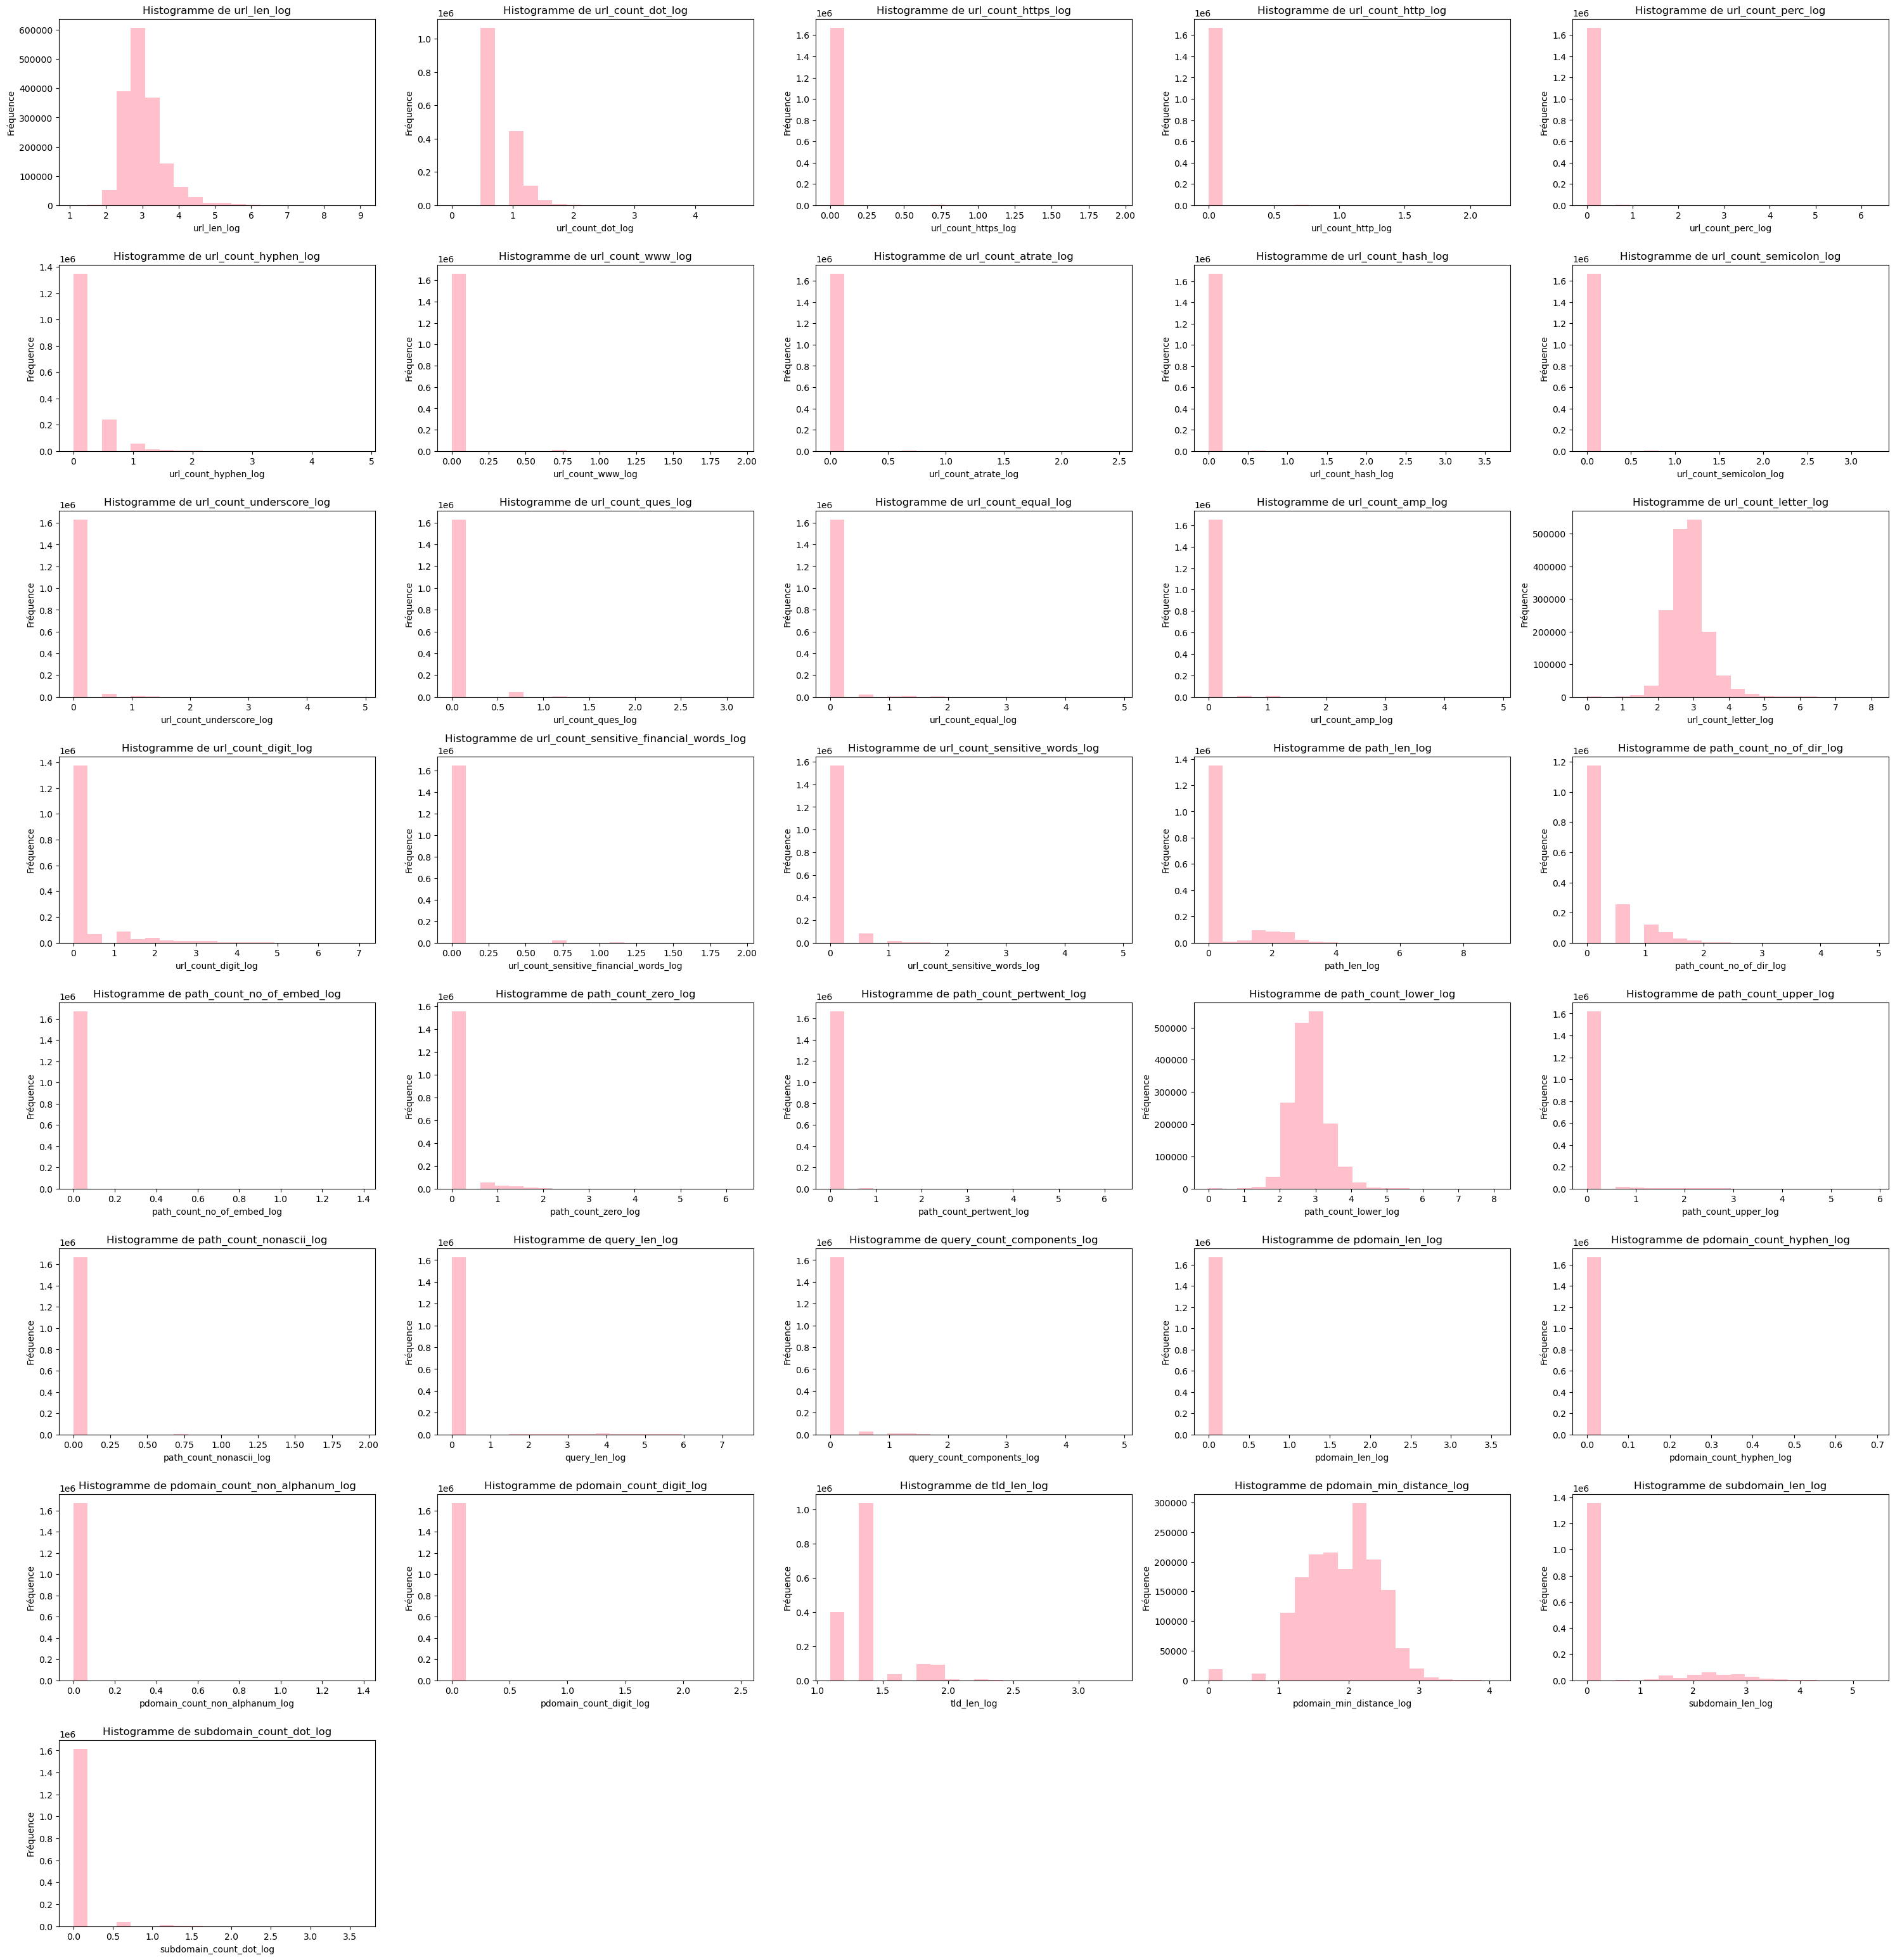

In [ ]:
histogram_plot(final_test, log_columns)

# 3. Création de Transformers et d'Estimators

## Transformers

In [ ]:
# Indexation de la colonne "source" pour la convertir en valeurs numériques
indexer = StringIndexer(inputCol="source", outputCol="sourceIndex")

filtered_feature_columns = [col for col in new_feature_columns if col != "source"]

# Assemblage des colonnes de features en un seul vecteur de caractéristiques
assembler = VectorAssembler(inputCols=filtered_feature_columns, outputCol="features")

# Normalisation des features pour les rendre de moyenne 0 et écart-type 1
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")


L'étape de StandardScaler est cruciale pour les modèles sensibles à l'échelle des données, comme la régression logistique. Pour des modèles basés sur des arbres, tels que les forêts aléatoires, cette étape est optionnelle, car ils sont insensibles à l'échelle.

## Estimators

In [ ]:
# Test de 2 classifiers
classifiers = [
    RandomForestClassifier(labelCol="label", featuresCol="features", impurity='gini', maxBins=32),
    LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.01)
    ]

Compte tenu du fort déséquilibre dans le jeu de données de test, nous avons décidé de choisir trois métriques : **F1-score**, **weighted precision** et **weighted recall** pour l'évaluation.

Il serait aussi pertinent d'analyser davantage les erreurs de classification en utilisant une matrice de confusion.

Test set f1 = 0.8731836770310848
Test set weightedPrecision = 0.8772232333068233
Test set weightedRecall = 0.8815798917217109
Type of classifier: RandomForestClassifier_db14eaa8394b
{Param(parent='RandomForestClassifier_db14eaa8394b', name='seed', doc='random seed.'): 7151660609306958655, Param(parent='RandomForestClassifier_db14eaa8394b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_db14eaa8394b', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='RandomForestClassifier_db14eaa8394b', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.

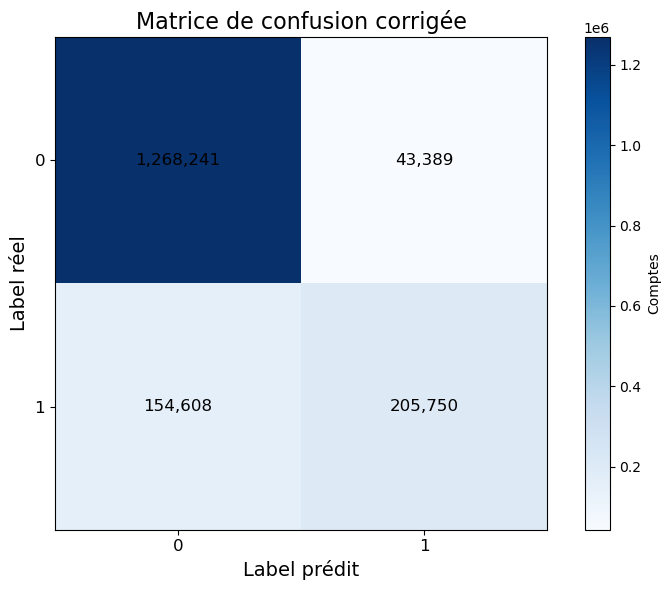

Test set f1 = 0.8804345156956989
Test set weightedPrecision = 0.8837939229199252
Test set weightedRecall = 0.8876427342779972
Type of classifier: LogisticRegression_e6148ad49b93
{Param(parent='LogisticRegression_e6148ad49b93', name='maxBlockSizeInMB', doc='maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0.'): 0.0, Param(parent='LogisticRegression_e6148ad49b93', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.5, Param(parent='LogisticRegression_e6148ad49b93', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_e6148ad49b93', name='standardization'

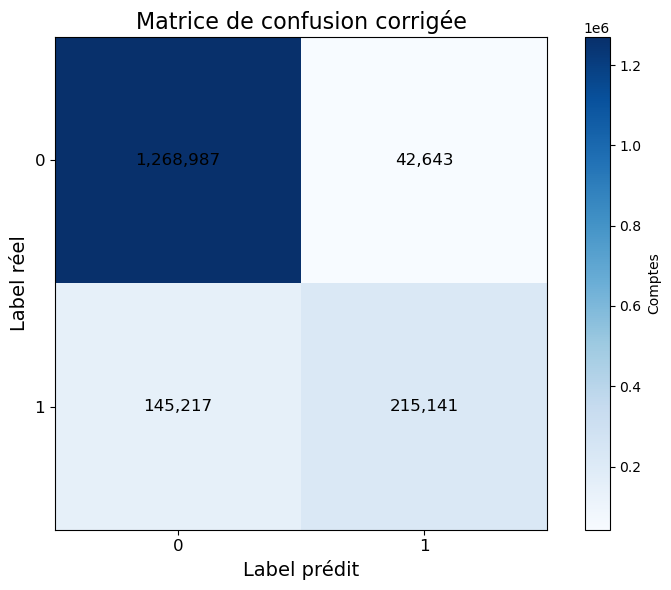

In [ ]:
metrics = ["f1", "weightedPrecision", "weightedRecall"]
labels = ["0", "1"]

for classifier in classifiers:
    # Definition du pipeline
    pipeline = Pipeline(stages=[indexer, assembler, scaler, classifier])

    # Apprentissage du modèle
    model = pipeline.fit(final_train)

    result = model.transform(final_test)

    predictionAndLabels = result.select("label", "prediction").persist(StorageLevel.MEMORY_AND_DISK)

    # Boucle pour évaluer chaque métrique
    for metric in metrics:
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
        metric_result = evaluator.evaluate(predictionAndLabels)
        print(f"Test set {metric} = {metric_result}")

    print(f"Type of classifier: {classifier}")
    print(classifier.extractParamMap())

    # Création de la matrice de confusion
    confusion_matrix = predictionAndLabels.groupBy("label", "prediction").count()

    # Convertir la matrice de confusion en un tableau numpy pour l'affichage
    confusion_matrix_values = confusion_matrix.collect()
    corrected_conf_matrix = np.array([[value['count'] for value in confusion_matrix_values if value['label'] == i and value['prediction'] == j]
                                      for i in range(len(labels)) for j in range(len(labels))]).reshape(len(labels), len(labels))

    # Tracer la matrice de confusion corrigée
    plt.figure(figsize=(8, 6))
    plt.imshow(corrected_conf_matrix, cmap="Blues", interpolation="nearest")
    plt.title("Matrice de confusion corrigée", fontsize=16)
    plt.colorbar(label='Comptes')

    # Ajouter des étiquettes aux axes
    plt.xticks(np.arange(len(labels)), labels, fontsize=12)
    plt.yticks(np.arange(len(labels)), labels, fontsize=12)
    plt.xlabel("Label prédit", fontsize=14)
    plt.ylabel("Label réel", fontsize=14)

    # Ajouter des annotations de texte pour chaque cellule
    for i in range(corrected_conf_matrix.shape[0]):
        for j in range(corrected_conf_matrix.shape[1]):
            plt.text(j, i, f"{corrected_conf_matrix[i, j]:,}", ha="center", va="center", color="black", fontsize=12)

    plt.tight_layout()
    plt.show()

    predictionAndLabels.unpersist()


Les deux modèles offrent une comparaison intéressante, avec une légère supériorité de la régression logistique.



Les modèles évalués, RandomForestClassifier et LogisticRegression, ont présenté des performances globalement satisfaisantes pour la détection des URL malveillantes, comme en témoignent leurs F1-scores respectifs de 0,873 et 0,880. Ces métriques mettent en évidence une précision et un rappel équilibrés, indiquant que les modèles parviennent à distinguer efficacement les URL bénignes des malveillantes.

En examinant les matrices de confusion :
1. Pour le **RandomForestClassifier** :
   - La majorité des URL bénignes ont été correctement identifiées (1 268 241 vrais négatifs).
   - Cependant, le modèle a généré 154 608 faux négatifs, soit des URL malveillantes classées comme bénignes.
2. Pour la **LogisticRegression** :
   - Une performance légèrement meilleure a été observée, avec 1 268 987 vrais négatifs et une réduction des faux négatifs (145 217).
   - Ce modèle présente également un meilleur équilibre entre précision pondérée (0,884) et rappel pondéré (0,887).

Ces résultats indiquent que, bien que les deux modèles soient performants, la **régression logistique** offre un avantage marginal, notamment en réduisant les erreurs de classification des URL malveillantes.

Malgré ces résultats prometteurs, des ajustements supplémentaires, tels que l'intégration d'autres fonctionnalités ou l'optimisation des hyperparamètres, pourraient améliorer encore la précision et la robustesse des modèles. De plus, une analyse approfondie des faux négatifs permettrait d’identifier des motifs ou des caractéristiques sous-représentés dans les données d’entraînement.


### **Conclusion** :
Dans le domaine de la cybersécurité, la détection des URL malveillantes est un enjeu crucial. Ce projet a exploré l'utilisation des données issues de caractéristiques variées pour concevoir des modèles d’apprentissage automatique et profond, capables de distinguer efficacement les URL bénignes des malveillantes. Grâce aux transformations des données, notamment la gestion des asymétries et la normalisation des caractéristiques, le projet a permis d’optimiser la préparation des données pour des algorithmes de classification.

Les résultats obtenus montrent des performances intéressantes, mesurées par des métriques telles que le F1-score, la précision pondérée et le rappel pondéré, démontrant le potentiel de ces modèles dans un contexte de données déséquilibrées. Toutefois, des analyses supplémentaires, comme l’interprétation fine des matrices de confusion et l'exploration de méthodes alternatives, pourraient améliorer encore la robustesse et l’efficacité des modèles. Ce travail offre une base solide pour le développement de solutions innovantes dans la lutte contre les menaces en ligne, tout en laissant place à des perspectives d'amélioration continue.

In [ ]:
spark.stop()